# Media Mixed Modelling with Bayesian statistics

In [1]:
# use poetry add `cat requirements.txt` for installain in req
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pymc3 as pm
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

In [2]:
spend_data = pd.read_excel('../data/mmm data.xlsx')

spend_data.head()

,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,sales
0,10.948187,13.224965,14.833617,14.784618,13.393616,11.606138,119.169990
1,10.679996,11.804500,12.556677,11.776853,9.704325,7.234834,107.297727
2,11.677359,13.693765,15.414623,15.479537,14.268762,12.544458,127.984427
3,10.362856,9.569667,8.876226,6.800466,3.751297,0.250574,72.891404
4,8.883413,4.852888,1.427800,0.000000,0.000000,0.000000,65.252818


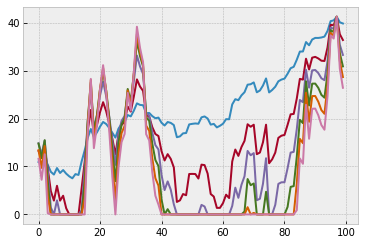

In [3]:
plt.plot(spend_data['channel_1'])
plt.plot(spend_data['channel_2'])
plt.plot(spend_data['channel_3'])
plt.plot(spend_data['channel_4'])
plt.plot(spend_data['channel_5'])
plt.plot(spend_data['channel_6'])

In [4]:
sales = (20 + spend_data['channel_1'] * 1.1 + spend_data['channel_2'] * 0.7 + 
         spend_data['channel_3'] * 0.8 + spend_data['channel_4'] *1.5 + 
         spend_data['channel_5'] * 0.8 + spend_data['channel_6'] * 0.95 +
         np.random.normal(20, 5, size=len(spend_data['channel_1']))
  )

sales = spend_data['sales'] # Use this to replicate my results exactly
spend_data = spend_data.drop('sales', axis=1)

In [5]:
spend_data.head()

,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6
0,10.948187,13.224965,14.833617,14.784618,13.393616,11.606138
1,10.679996,11.804500,12.556677,11.776853,9.704325,7.234834
2,11.677359,13.693765,15.414623,15.479537,14.268762,12.544458
3,10.362856,9.569667,8.876226,6.800466,3.751297,0.250574
4,8.883413,4.852888,1.427800,0.000000,0.000000,0.000000


In [6]:
sales

0     119.169990
1     107.297727
2     127.984427
3      72.891404
4      65.252818
         ...    
95    266.526427
96    277.599515
97    276.675519
98    240.246990
99    223.424473
Name: sales, Length: 100, dtype: float64

In [7]:
spend_data_with_c = sm.add_constant(spend_data)
est = sm.OLS(sales, spend_data_with_c).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2732.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):          3.12e-102
Time:                        23:30:21   Log-Likelihood:                -295.00
No. Observations:                 100   AIC:                             604.0
Df Residuals:                      93   BIC:                             622.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.6028      1.512     26.199      0.000      36.601      42.605
channel_1      1.1283      0.168      6.710      0.000       0.794       1.462
channel_2      0.6606      0.369      1.788      0.077      -0.073       1.394
channel_3      0.4910      0.517      0.949      0.345      -0.536       1.518
channel_4      2.5278      0.704      3.588      0.001       1.129       3.927
channel_5     -0.8799      0.859     -1.025      0.308      -2.585       0.825
channel_6      1.9833      0.500      3.964      0.000       0.990       2.977
==============================================================================
Omnibus:                        1.712   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                1.707
Skew:                           0.305   Prob(JB):                        0.426
Kurtosis:                       2.803   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
with pm.Model() as model:
    sigma = pm.HalfNormal("sigma", sigma=1)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    beta = pm.Normal("x", 0, sigma=20, shape = 6)
    mu = intercept + beta[0] * spend_data['channel_1'] \
                   + beta[1] * spend_data['channel_2'] \
                   + beta[2] * spend_data['channel_3'] \
                   + beta[3] * spend_data['channel_4'] \
                   + beta[4] * spend_data['channel_5'] \
                   + beta[5] * spend_data['channel_6']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=sales)

    # pm.glm.GLM.from_formula("y ~ x", data)
    ols_trace = pm.sample(2000, cores=2)

/var/folders/pk/f_w9xjw57l3_b9hlyplw1pym0000gn/T/ipykernel_48947/1666377863.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  ols_trace = pm.sample(2000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 35 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
ols_trace_df = pm.trace_to_dataframe(ols_trace)
res = ols_trace_df.describe().filter(['mean'],axis=0).T
res.index=['Intercept', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5', 'beta_6', 'sigma']
res

,mean
Intercept,39.374227
beta_1,1.147478
beta_2,0.638136
beta_3,0.502164
beta_4,2.524303
beta_5,-0.866982
beta_6,1.973550
sigma,4.405032


In [11]:
with pm.Model() as model:
    sigma = pm.HalfNormal("sigma", sigma=1)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    beta = BoundedNormal("x", 0, sigma=20, shape = 6)
    mu = intercept + beta[0] * spend_data['channel_1'] \
                   + beta[1] * spend_data['channel_2'] \
                   + beta[2] * spend_data['channel_3'] \
                   + beta[3] * spend_data['channel_4'] \
                   + beta[4] * spend_data['channel_5'] \
                   + beta[5] * spend_data['channel_6']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=sales)


    # pm.glm.GLM.from_formula("y ~ x", data)
    bounded_trace = pm.sample(2000, cores=2)

/var/folders/pk/f_w9xjw57l3_b9hlyplw1pym0000gn/T/ipykernel_48947/4005999278.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  bounded_trace = pm.sample(2000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 23 seconds.
There were 349 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1077 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.41086591115325594, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
bounded_trace_df = pm.trace_to_dataframe(bounded_trace)
res= bounded_trace_df.describe().filter(['mean'],axis=0).T
res.index=['Intercept', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5', 'beta_6', 'sigma']
res

,mean
Intercept,39.653515
beta_1,4.397311
beta_2,1.128184
beta_3,0.566836
beta_4,0.880964
beta_5,1.552468
beta_6,0.521011
sigma,1.246430


In [13]:
bt_means = bounded_trace_df[['Intercept','x__0','x__1','x__2','x__3','x__4', 'x__5']].mean().values
ols_means = ols_trace_df[['Intercept','x__0','x__1','x__2','x__3','x__4', 'x__5']].mean().values

In [14]:
pd.DataFrame({'Truth':np.array([20, 1.1, 0.7, 0.8, 1.5, 0.8, 0.95]), 'ols':est.params, 'bayes_ols':ols_means, 'bounded':bt_means})

,Truth,ols,bayes_ols,bounded
const,20.00,39.602849,39.374227,39.653515
channel_1,1.10,1.128318,1.147478,1.128184
channel_2,0.70,0.660571,0.638136,0.566836
channel_3,0.80,0.491001,0.502164,0.880964
channel_4,1.50,2.527781,2.524303,1.552468
channel_5,0.80,-0.879944,-0.866982,0.521011
channel_6,0.95,1.983264,1.973550,1.246430
